In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib notebook

from scipy import signal

from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objects as go
from scipy.ndimage import gaussian_filter1d

from plotly.subplots import make_subplots

init_notebook_mode(connected=True)

import seaborn as sns

sns.set_theme()

plt.rcParams.update({
    'axes.titlesize': 'xx-large',
    'axes.labelsize': 'x-large',
    'xtick.labelsize': 'x-large',
    'ytick.labelsize': 'x-large',
})

In [3]:
df = pd.read_csv('data/capture_mcu_input.csv', names=('raw_current', 'busvoltage', 'raw_shuntvoltage', 'power'))
print(df.head())

df_current = gaussian_filter1d(df['raw_current'] / 20, 3)
df_voltage = df['busvoltage'] / 1000

x = np.arange(len(df_current)) * 10

current_line = go.Scatter(x=x, y=df_current, name='I (mA)')
voltage_line = go.Scatter(x=x, y=df_voltage, name='Vbus (V)')

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(current_line, secondary_y=False)
fig.add_trace(voltage_line, secondary_y=True)

fig.update_layout(title_text='V/I measured coming into MCU')
fig.update_xaxes(title_text='T (ms)')

fig.show()

   raw_current  busvoltage  raw_shuntvoltage  power
0          522        6604               502    331
1          480        6696               500    329
2          484        6748               425    280
3          520        6604               505    333
4          478        6696               499    329


In [4]:
df_sweep = pd.read_csv('data/capture_psu_sweep.csv', names=('raw_current', 'busvoltage', 'raw_shuntvoltage', 'power'))

df_current = df_sweep['raw_current'] / 20
df_voltage = df_sweep['busvoltage'] / 1000

# df_current = (df_current - min(df_current)) / (max(df_current) - min(df_current))
# df_voltage = (df_voltage - min(df_voltage)) / (max(df_voltage) - min(df_voltage))

x = np.arange(len(df_current)) * 0.010

current_line = go.Scatter(x=x, y=df_current, name='I (mA)')
voltage_line = go.Scatter(x=x, y=df_voltage, name='Vbus (V)')

fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(current_line, secondary_y=False)
fig.add_trace(voltage_line, secondary_y=True)

fig.update_layout(title_text='V/I measured coming into MCU using PSU sweep from 7-8V')
fig.update_xaxes(title_text='T (s)')

fig.show()

In [5]:
from pathlib import Path

data_path = Path('data/samples')
dfs = {}

for sample_file in data_path.glob('*'):
    filename = sample_file.stem.split('_')
    flowrate = float(filename[-2] + '.' + filename[-1])
    dfs[flowrate] = pd.read_csv(sample_file, names=('raw_current', 'busvoltage', 'raw_shuntvoltage', 'power'))

dfs = dict(sorted(dfs.items(), key=lambda d: d[0]))
print('flowrates:', dfs.keys())

flowrates: dict_keys([7.5, 7.8, 8.0, 8.3, 8.5, 8.7, 9.0, 9.3, 9.5, 9.8])


In [6]:
from scipy import signal
from scipy import fftpack

df_current = dfs[7.5]['raw_current'] / 20
df_voltage = dfs[7.5]['busvoltage'] / 1000
df_power = dfs[7.5]['power']

x = np.arange(len(df_current)) * 0.010
fs = 1 / 0.01

fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=df_current, name='I (mA)'))
fig.add_trace(go.Scatter(x=x, y=df_voltage, name='Vbus (V)', yaxis='y2'))
fig.add_trace(go.Scatter(x=x, y=df_power, name='P (mW)', yaxis='y3'))

fig.update_layout(
    xaxis=dict(
        title='T (s)',
        domain=[0.05, 1],
        range=[0, 1],
    ),
    yaxis=dict(
        position=0.0
    ),
    yaxis2=dict(
        anchor="free",
        overlaying="y",
        side="left",
        position=0.05
    ),
    yaxis3=dict(
        anchor="x",
        overlaying="y",
        side="right"
    )
)

fig.update_layout(
    title_text='V,I,P measured coming into cap at flowrate of 7.5 l/min',
    width=900,
    margin=dict(l=0, r=0, t=100, b=0),
    font=dict(
        size=14,
    )
)


fig.show()
fig.write_image('zoomed_in_voltage_current_power.pdf')

sos = signal.butter(10, 7, 'lowpass', fs=fs, output='sos')
voltage_filtered = signal.sosfilt(sos, df_voltage)
current_filtered = signal.sosfilt(sos, df_current)

fig = make_subplots(specs=[[{"secondary_y": True}]])
start_xi = 55
fig.add_trace(go.Scatter(x=x + start_xi * 0.01, y=voltage_filtered[start_xi:], name='Vbus (V)'), secondary_y=True)
fig.add_trace(go.Scatter(x=x + start_xi * 0.01, y=current_filtered[start_xi:], name='I (mA)'), secondary_y=False)
fig.update_layout(title_text='Low-pass filtered V/I measured coming into cap at flowrate of 7.5 l/min')
fig.update_xaxes(title_text='T (s)')
fig.show()

In [7]:
fig = make_subplots(rows=3, cols=1, 
                    subplot_titles=('Current', 'Busvoltage', 'Power'), 
                    shared_xaxes=True, vertical_spacing=0.1)

fig.add_trace(go.Scatter(x=x, y=df_current, name='I (mA)'), row=1, col=1)
fig.add_trace(go.Scatter(x=x, y=df_voltage, name='Vbus (V)', yaxis='y2'), row=2, col=1)
fig.add_trace(go.Scatter(x=x, y=df_power, name='P (mW)', yaxis='y3'), row=3, col=1)

fig.update_xaxes(title_text='T (s)', row=3, col=1)
fig.update_layout(
    title_text='V,I,P measured coming into cap at flowrate of 7.5 l/min', 
    margin=dict(l=0, r=0, t=100, b=0),
    width=900,
    height=900,
    font=dict(
        size=18,
    )
)

fig.show()
fig.write_image('voltage_current_power.pdf')

In [8]:
df_no_cap = pd.read_csv('data/capture_7_8_no_cap.csv', names=('busvoltage', 'raw_current', 'raw_shuntvoltage', 'power'))

sos = signal.butter(10, 7, 'lowpass', fs=fs, output='sos')
voltage_filtered = signal.sosfilt(sos, df_no_cap['busvoltage'] / 1000)
current_filtered = signal.sosfilt(sos, df_no_cap['raw_current'] / 20)

fig = make_subplots(specs=[[{"secondary_y": True}]])
start_xi = 55
fig.add_trace(go.Scatter(x=x + start_xi * 0.01, y=voltage_filtered[start_xi:], name='Vbus (V)'), secondary_y=True)
fig.add_trace(go.Scatter(x=x + start_xi * 0.01, y=current_filtered[start_xi:], name='I (mA)'), secondary_y=False)
fig.update_layout(title_text='Low-pass filtered V/I measured coming into cap at flowrate of 7.5 l/min without capacitor')
fig.update_xaxes(title_text='T (s)')
fig.show()

<IPython.core.display.Javascript object>


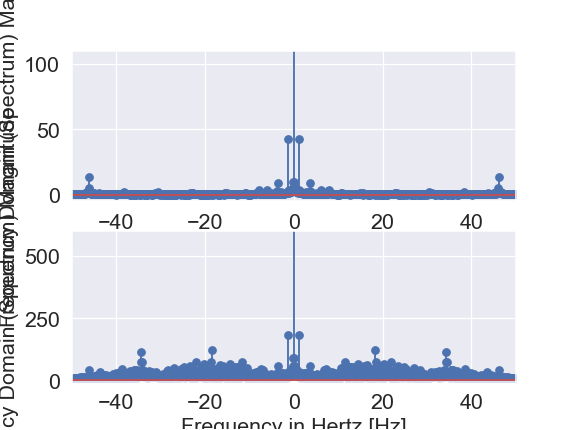

Strongest V wave
-3.62319 Hz  -  9.01  -  2.47669 rad
46.13527 Hz  -  13.14  -  1.85937 rad
-46.13527 Hz  -  13.14  -  -1.85937 rad
1.20773 Hz  -  42.16  -  -2.03739 rad
-1.20773 Hz  -  42.16  -  2.03739 rad
Strongest I wave
-34.29952 Hz  -  113.42  -  -2.49414 rad
18.35749 Hz  -  121.94  -  2.94654 rad
-18.35749 Hz  -  121.94  -  -2.94654 rad
1.20773 Hz  -  181.31  -  1.23656 rad
-1.20773 Hz  -  181.31  -  -1.23656 rad


In [9]:
import matplotlib.pyplot as plt

V = df_voltage.to_numpy()
X = fftpack.fft(V)
freqs = fftpack.fftfreq(len(df_voltage)) * fs

fig, (ax0, ax1) = plt.subplots(nrows=2)

ax0.stem(freqs, np.abs(X))

ax0.set_xlabel('Frequency in Hertz [Hz]')
ax0.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax0.set_xlim(-fs / 2, fs / 2)
ax0.set_ylim(-5, 110)

fig.show()

peaks, _ = signal.find_peaks(np.abs(X))
strongest_magnitudes = sorted(zip(freqs[peaks], np.abs(X)[peaks], np.angle(X)[peaks]), key=lambda x: x[1])
print('Strongest V wave')
for f, m, w in strongest_magnitudes[-5:]:
    print(f'{f:.05f} Hz  -  {m:.02f}  -  {w:.05f} rad')

I = df_current.to_numpy()
X = fftpack.fft(I)
freqs = fftpack.fftfreq(len(df_current)) * fs

ax1.stem(freqs, np.abs(X))

ax1.set_xlabel('Frequency in Hertz [Hz]')
ax1.set_ylabel('Frequency Domain (Spectrum) Magnitude')
ax1.set_xlim(-fs / 2, fs / 2)
ax1.set_ylim(-5, 600)

fig.show()

peaks, _ = signal.find_peaks(np.abs(X))
strongest_magnitudes = sorted(zip(freqs[peaks], np.abs(X)[peaks], np.angle(X)[peaks]), key=lambda x: x[1])
print('Strongest I wave')
for f, m, w in strongest_magnitudes[-5:]:
    print(f'{f:.05f} Hz  -  {m:.02f}  -  {w:.05f} rad')

In [10]:
def calc_phase_shift(x0, x1, fs):
    X = fftpack.fft(x0)
    freqs = fftpack.fftfreq(len(x)) * fs
    peaks, _ = signal.find_peaks(np.abs(X))
    index_strongest_mag = np.argmax(np.abs(X)[peaks])
    phase0 = np.angle(X)[peaks][index_strongest_mag]

    X = fftpack.fft(x1)
    freqs = fftpack.fftfreq(len(x)) * fs
    peaks, _ = signal.find_peaks(np.abs(X))
    index_strongest_mag = np.argmax(np.abs(X)[peaks])
    phase1 = np.angle(X)[peaks][index_strongest_mag]
    
    return np.abs(phase0 - phase1)


for fr, df in dfs.items():
    print(fr, calc_phase_shift(df['busvoltage'].to_numpy(), df['raw_current'].to_numpy(), fs))
    
print('7.5 (no capacitor)', calc_phase_shift(df_no_cap['busvoltage'].to_numpy(), df_no_cap['raw_current'].to_numpy(), fs))

7.5 3.273956822380377
7.8 3.080153014595166
8.0 3.624601176960155
8.3 2.97565426767669
8.5 2.8849286218115977
8.7 3.3030219759593282
9.0 3.0649300953874947
9.3 3.213695524169861
9.5 3.180590673708374
9.8 2.984081439375366
7.5 (no capacitor) 1.804964736693758


<IPython.core.display.Javascript object>


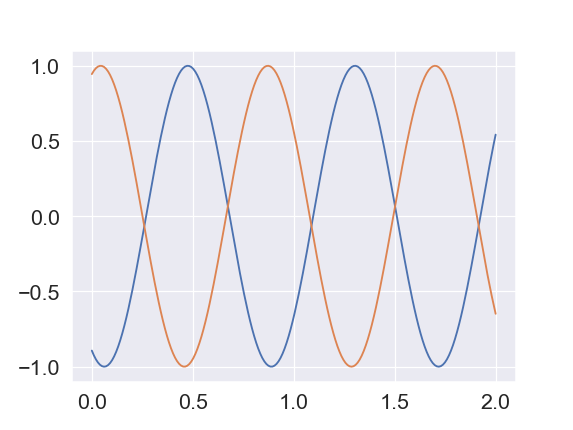

Phase shift is 3.27395 radians = 187.58 degrees


In [11]:
t = np.linspace(0, 2, int(2*fs))
V = np.sin(1.20773 * 2 * np.pi * t + -2.03739)
I = np.sin(1.20773 * 2 * np.pi * t + 1.23656)

fig, ax = plt.subplots()

ax.plot(t, V)
ax.plot(t, I)

fig.show()

print(f'Phase shift is {np.abs(2.03739 + 1.23656)} radians = {np.degrees(2.03739 + 1.23656):.02f} degrees')

<IPython.core.display.Javascript object>


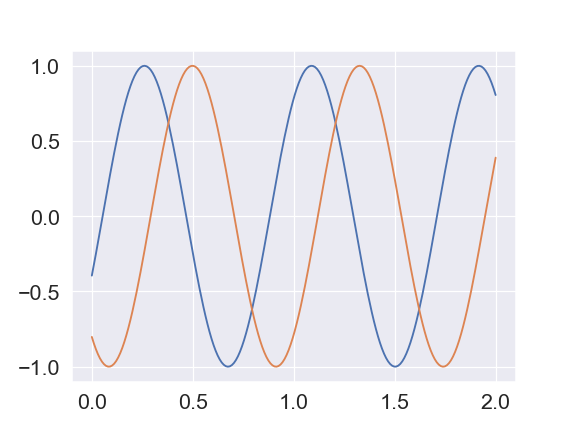

Phase shift is 3.27395 radians = 187.58 degrees


In [12]:
t = np.linspace(0, 2, int(2*fs))
V = np.sin(1.20773 * 2 * np.pi * t + -0.4056219567073067)
I = np.sin(1.20773 * 2 * np.pi * t + -2.2105866934010647)

fig, ax = plt.subplots()

ax.plot(t, V)
ax.plot(t, I)

fig.show()

print(f'Phase shift is {np.abs(2.03739 + 1.23656)} radians = {np.degrees(2.03739 + 1.23656):.02f} degrees')

In [13]:
fig = make_subplots()

x = np.arange(min(len(df) for df in dfs.values())) * 0.01

for flowrate, df in dfs.items():
    fig.add_trace(go.Scatter(x=x, y=df['busvoltage'] / 1000, name=f'Vbus ({flowrate} l/min)'))
    
fig.show()

<IPython.core.display.Javascript object>


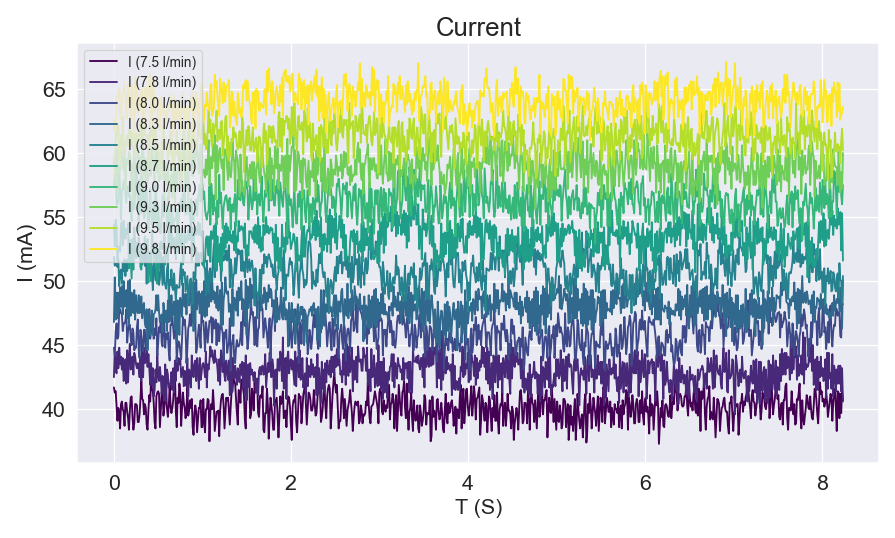

In [14]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.set_prop_cycle(plt.cycler('color', plt.cm.viridis(np.linspace(0, 1, len(dfs)))))

for flowrate, df in dfs.items():
    ax.plot(x, list(df['raw_current'] / 20)[:825], label=f'I ({flowrate} l/min)')
#     fig.add_trace(go.Scatter(x=x, y=df['raw_current'] / 20, name=f'I ({flowrate} l/min)'))

ax.set_xlabel('T (S)')
ax.set_ylabel('I (mA)')
ax.set_title('Current')
ax.legend()

fig.tight_layout()
fig.show()

In [15]:
from collections import defaultdict

features = defaultdict(list)

for fr, df in dfs.items():
    
    for window in list(df.rolling(100))[::100]:
    
        voltage = window['busvoltage'] / 1000
        current = window['raw_current'] / 20
        power = window['power']
        shuntvoltage = window['raw_shuntvoltage']

        features['flowrate'].append(fr)
        features['V_max'].append(voltage.max())
        features['V_min'].append(voltage.min())
        features['V_mean'].append(voltage.mean())
        features['V_midrange'].append(voltage.min() + (voltage.max() - voltage.min()) / 2)
        features['I_mean'].append(current.mean())
        features['P_mean'].append(power.mean())
        features['P_min'].append(power.min())
        features['P_max'].append(power.max())
        features['Vs_mean'].append(shuntvoltage.mean())
    
df_features = pd.DataFrame(data=features)
df_features.head()

flowrate  V_max  V_min   V_mean  V_midrange  I_mean  P_mean  P_min  P_max  \
0       7.5  7.432  7.432  7.43200       7.432  41.700  303.00    303    303   
1       7.5  7.596  7.304  7.45484       7.450  40.146  298.94    282    316   
2       7.5  7.580  7.340  7.46608       7.460  40.290  300.48    283    316   
3       7.5  7.588  7.320  7.46008       7.454  40.344  300.55    283    316   
4       7.5  7.548  7.256  7.40364       7.402  39.987  295.79    277    311   

   Vs_mean  
0   412.00  
1   404.19  
2   405.34  
3   406.11  
4   402.14

In [16]:
import scipy

def curve(x, a, b):
    return a * x + b

popt, _ = scipy.optimize.curve_fit(curve, features['flowrate'], features['V_mean'])
print(f'{popt[0]:.30f} {popt[1]:.30f}')

fig = make_subplots()
fig.add_trace(go.Scatter(x=features['flowrate'], y=features['V_mean'], name='Vmean', mode='markers'))
fig.add_trace(go.Scatter(x=features['flowrate'], y=features['V_max'], name='Vmax', mode='markers'))
fig.add_trace(go.Scatter(x=features['flowrate'], y=features['V_min'], name='Vmin', mode='markers'))

# flowrates_curve = np.linspace(7.5, 10, 1000)
# fig.add_trace(go.Scatter(x=flowrates_curve, y=curve(flowrates_curve, *popt), name='Curve'))

fig.show()

1.101576386458836598336574752466 -0.885962354977734678485035146878


148.878450006043067332939244806767 -830.308195371144961427489761263132


<IPython.core.display.Javascript object>


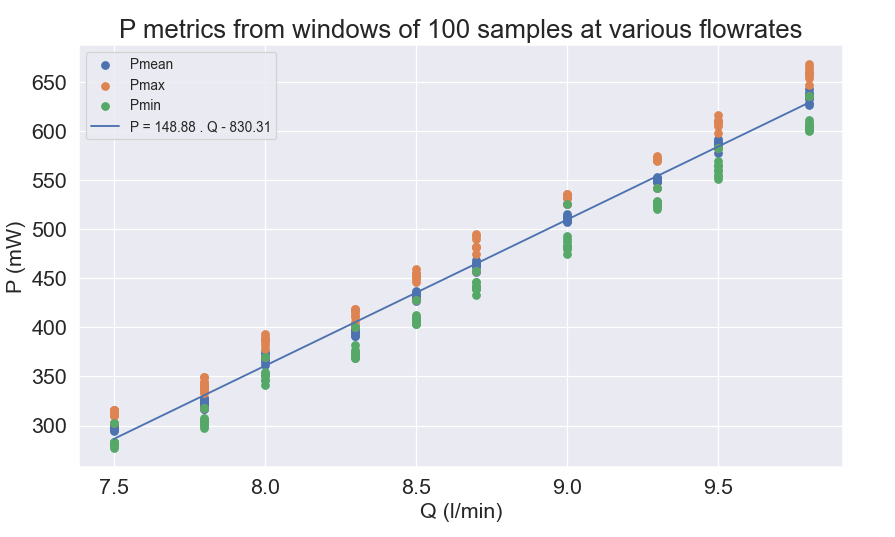

In [17]:
popt, _ = scipy.optimize.curve_fit(curve, features['flowrate'], features['P_mean'])
print(f'{popt[0]:.30f} {popt[1]:.30f}')

# fig = make_subplots()
# fig.add_trace(go.Scatter(x=features['flowrate'], y=features['P_mean'], name='P mean', mode='markers'))

# fig.update_layout(
#     title_text='Mean P (mW) of windows of 100 samples at various flowrates', 
#     margin=dict(l=0, r=0, t=100, b=0),
#     font=dict(
#         size=14,
#     )
# )
# fig.show()

fig, ax = plt.subplots(figsize=(10, 6))
fig.tight_layout(pad=2.5)

# ax.scatter(x=features['flowrate'], y=features['P_mean'])
ax.scatter(x=features['flowrate'], y=features['P_mean'], label='Pmean')
ax.scatter(x=features['flowrate'], y=features['P_max'], label='Pmax')
ax.scatter(x=features['flowrate'], y=features['P_min'], label='Pmin')

ax.plot(
    [7.5, 9.8], 
    [curve(7.5, popt[0], popt[1]), curve(9.8, popt[0], popt[1])], 
    label=f'P = {popt[0]:.2f} . Q - {-popt[1]:.2f}'
)

ax.set_title('P metrics from windows of 100 samples at various flowrates')
ax.set_xlabel('Q (l/min)')
ax.set_ylabel('P (mW)')

ax.legend()

plt.show()

In [18]:
fig = make_subplots()
fig.add_trace(go.Scatter(x=features['flowrate'], y=features['Vs_mean'], name='Vs mean'))

popt, _ = scipy.optimize.curve_fit(curve, features['flowrate'], features['Vs_mean'])
print(f'{popt[0]:.30f} {popt[1]:.30f}')

fig.show()

105.017249625021960923731967341155 -383.399696774108008412440540269017


In [19]:
def predict_flowrate_from_V(samples) -> float:
    return (samples['busvoltage'].mean() / 1000)
    
def predict_flowrate_from_V_curve(samples) -> float:
    a = 1.093291873776151446051585480745
    b = -0.807589438289406880144838396518
    return ((samples['busvoltage'].mean() / 1000) - b) / a

def predict_flowrate_from_P(samples) -> float:
    a = 148.450205494820409057865617796779 
    b = -826.204954144229304802138358354568
    return (samples['power'].mean() - b) / a


for window_size in (10, 20, 50, 100):
    print(f'window_size = {window_size} = {window_size / fs} s')

    for metric in (predict_flowrate_from_V, predict_flowrate_from_V_curve, predict_flowrate_from_P):
        total_error = 0
        total_samples = 0

        for fr, df in dfs.items():
            for window_start in range(0, len(df), window_size):
                if window_start + window_size >= len(df):
                    break

                samples = df.iloc[window_start:window_start + window_size]

                predicted_fr = metric(samples)

                total_error += (predicted_fr - fr)**2
                total_samples += 1

        print(f'MSE for {metric.__name__}: {total_error / total_samples}')

window_size = 10 = 0.1 s
MSE for predict_flowrate_from_V: 0.015524446189376411
MSE for predict_flowrate_from_V_curve: 0.008383372936223687
MSE for predict_flowrate_from_P: 0.0034284939316375418
window_size = 20 = 0.2 s
MSE for predict_flowrate_from_V: 0.014456991131639707
MSE for predict_flowrate_from_V_curve: 0.007490319678352851
MSE for predict_flowrate_from_P: 0.003174106895138164
window_size = 50 = 0.5 s
MSE for predict_flowrate_from_V: 0.010584691616568038
MSE for predict_flowrate_from_V_curve: 0.004373340688360388
MSE for predict_flowrate_from_P: 0.0028323733869517914
window_size = 100 = 1.0 s
MSE for predict_flowrate_from_V: 0.008840535561904724
MSE for predict_flowrate_from_V_curve: 0.002988869835896838
MSE for predict_flowrate_from_P: 0.002552921739128879


In [20]:
np.random.seed(0)

results = []

for window_size in (10, 20, 50, 100):
    all_samples = []
    
    # Pre-processing
    for fr, df in dfs.items():
        for window_start in range(0, len(df), window_size):
            if window_start + window_size >= len(df):
                break
                
            samples = df.iloc[window_start:window_start + window_size]
            
            v_shunt = np.mean(signal.sosfilt(sos, samples['raw_shuntvoltage']))
            v_bus = np.mean(signal.sosfilt(sos, samples['busvoltage'] / 1000))
            current = np.mean(signal.sosfilt(sos, samples['raw_current'] / 20))
            power = np.mean(signal.sosfilt(sos, samples['power']))
            
            all_samples.append((fr, v_shunt, v_bus, current, power))
    
    metrics = ['Vshunt', 'Vbus', 'I', 'P']
    df_all = pd.DataFrame(all_samples, columns=['Q', *metrics])
    
    mask = np.random.rand(len(df_all)) < 0.8
    
    df_train = df_all[mask]
    df_test = df_all[~mask]
    
    result = {'Window Size': window_size}
    
    for metric in metrics:        
        (a, b), _ = scipy.optimize.curve_fit(curve, df_train['Q'], df_train[metric])
 
        total_error = 0
        total_samples = 0
        
        for sample in df_test.to_dict(orient='records'):
            predicted_flowrate = (sample[metric] - b) / a
            total_error += (predicted_flowrate - sample['Q'])**2
            total_samples += 1
        
        result[metric] = total_error / total_samples
        
    results.append(result)

    
print(pd.DataFrame(results).to_latex(index=False))

\begin{tabular}{rrrrr}
\toprule
 Window Size &   Vshunt &     Vbus &        I &        P \\
\midrule
          10 & 0.006658 & 0.008867 & 0.007870 & 0.003822 \\
          20 & 0.006436 & 0.007195 & 0.004882 & 0.004081 \\
          50 & 0.003235 & 0.004738 & 0.003979 & 0.002394 \\
         100 & 0.001560 & 0.002821 & 0.001522 & 0.002465 \\
\bottomrule
\end{tabular}



/var/folders/1l/pwf6x1q91xg21x1mgv59t9ph0000gn/T/ipykernel_2098/2988626787.py:49: FutureWarning:

In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.



# Noise

<IPython.core.display.Javascript object>


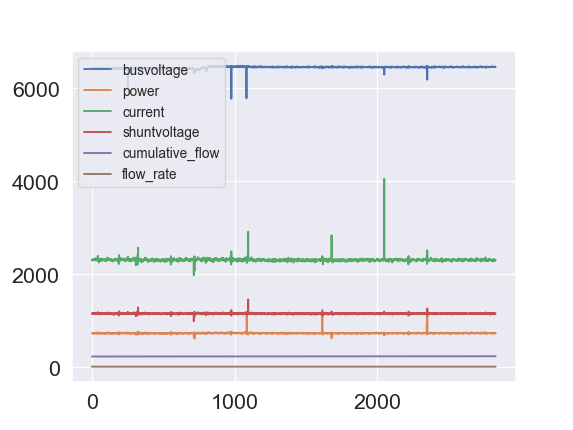

busvoltage  power  current  shuntvoltage  cumulative_flow  flow_rate
0        6428    726     2308          1154       229.248840   10.42912
1        6420    729     2316          1159       229.250580   10.42912
2        6432    731     2294          1149       229.252319   10.42912
3        6424    727     2306          1153       229.254059   10.42912
4        6420    727     2306          1153       229.255798   10.42912

In [21]:
df_noise = pd.read_json('data/noise_7v.jsonl', lines=True)
df_noise.plot()
df_noise.head()

<IPython.core.display.Javascript object>


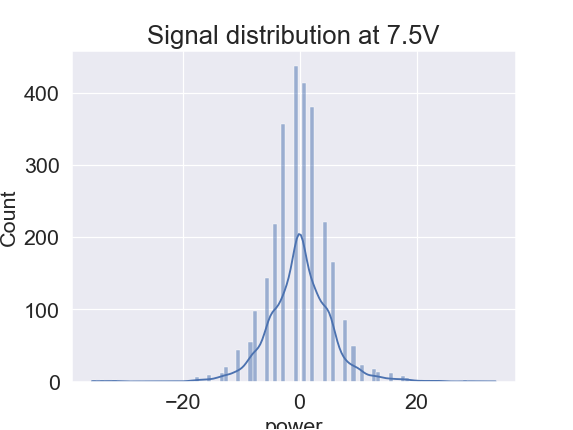

mean 731.5001772421127
std 5.6966224256810865


In [22]:
metric = 'power'

upper_limit = df_noise[metric].mean() + 2*df_noise[metric].std()
lower_limit = df_noise[metric].mean() - 2*df_noise[metric].std()

# df_noise_no_out = np.where(
#     df_noise[metric] > upper_limit,
#     upper_limit,
#     np.where(
#         df_noise[metric] < lower_limit,
#         lower_limit,
#         df_noise[metric]
#     )
# )

df_noise_no_out = df_noise[metric][df_noise[metric] < upper_limit]
df_noise_no_out = df_noise_no_out[df_noise_no_out > lower_limit]

fig, ax = plt.subplots()
sns.histplot(df_noise_no_out - df_noise_no_out.mean(), kde=True, ax=ax)
ax.set_title('Signal distribution at 7.5V')

print('mean', df_noise_no_out.mean())
print('std', df_noise_no_out.std())

<IPython.core.display.Javascript object>


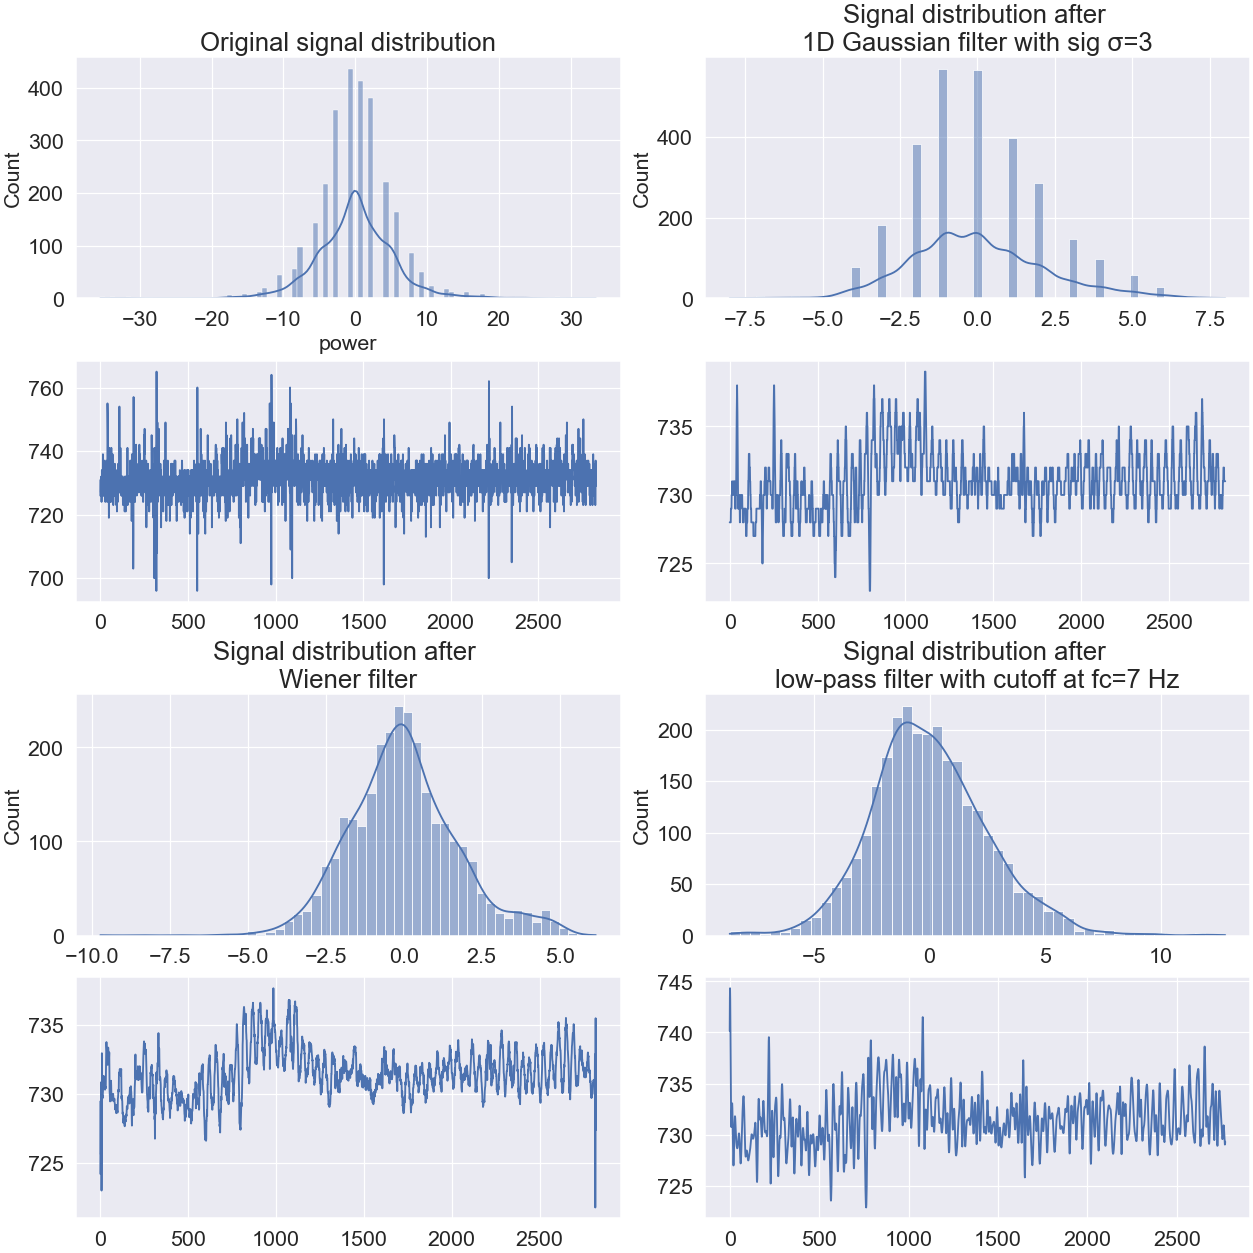

In [23]:
from scipy.ndimage import gaussian_filter1d
from scipy.signal import wiener

df_noise_gauss = gaussian_filter1d(df_noise_no_out, sigma=3)
df_noise_wien = wiener(df_noise_no_out, mysize=20)
df_noise_lp = signal.sosfilt(sos, df_noise_no_out)[50:]

fig, axes = plt.subplots(4, 2, figsize=(14, 14), layout='constrained')
# plt.tight_layout(w_pad=0.6, h_pad=5.0)

sns.histplot(df_noise_no_out - df_noise_no_out.mean(), ax=axes[0, 0], kde=True, )
sns.histplot(df_noise_gauss - df_noise_gauss.mean(), ax=axes[0, 1], kde=True)
sns.histplot(df_noise_wien - df_noise_wien.mean(), ax=axes[2, 0], kde=True)
sns.histplot(df_noise_lp - df_noise_lp.mean(), ax=axes[2, 1], kde=True)

axes[0, 0].set_title('Original signal distribution')
axes[0, 1].set_title('Signal distribution after \n1D Gaussian filter with sig \u03c3=3')
axes[2, 0].set_title('Signal distribution after \nWiener filter')
axes[2, 1].set_title('Signal distribution after \nlow-pass filter with cutoff at fc=7 Hz')

axes[1, 0].plot(df_noise_no_out)
axes[1, 1].plot(df_noise_gauss)
axes[3, 0].plot(df_noise_wien)
axes[3, 1].plot(df_noise_lp)

# axes[1].plot(df_noise_no_out)
# axes[2].plot(df_noise_filtered)

# Validation

In [24]:
dfs_cumulative = {}

for sample_file in Path('data').glob('capture_cumulative*'):
    filename = sample_file.stem.split('_')
    total_flow = float(filename[-2] + '.' + filename[-1])
    dfs_cumulative[total_flow] = pd.read_csv(sample_file, names=('busvoltage', 'raw_current', 'raw_shuntvoltage', 'power', 'estimated_flowrate', 'cumulative_flow'))

fig = make_subplots()

x = np.arange(max(len(df) for df in dfs.values())) * 0.01

for total_flow, df in dfs_cumulative.items():
    power_lpm = (df['power'] + 826.204954144229304802138358354568) / 148.450205494820409057865617796779
    calculated_flow = (power_lpm.mean() / 60 / 1000) * 0.01
    
    print(f'ground_truth={total_flow} (l) measured={df["cumulative_flow"].iloc[-1]} (l)')
    fig.add_trace(go.Scatter(x=x, y=df['power'], name=f'P ({total_flow} l)'))
    
    
fig.show()

ground_truth=8.3 (l) measured=8.41641 (l)
ground_truth=10.3 (l) measured=10.416638 (l)
ground_truth=14.4 (l) measured=14.388371 (l)


In [25]:
data_path = Path('data/samples_2')
dfs = {}

for sample_file in data_path.glob('*.jsonl'):
    filename = sample_file.stem.split('_')
    flowrate = float(filename[-2] + '.' + filename[-1])
    dfs[flowrate] = pd.read_json(sample_file, lines=True)

dfs = dict(sorted(dfs.items(), key=lambda d: d[0]))
print('flowrates:', dfs.keys())

fig = make_subplots()

x_esp = np.arange(min(len(df) for df in dfs.values())) * 0.01

for flowrate, df in dfs.items():
    fig.add_trace(go.Scatter(x=x_esp, y=df['power'], name=f'Vbus ({flowrate} l/min)'))
    
fig.show()

all_samples = []

# Pre-processing
window_size = 100
for fr, df in list(dfs.items())[1:]:
    for window_start in range(0, 850, window_size):
        if window_start + window_size >= len(df):
            break

        samples = df.iloc[window_start:window_start + window_size]

        v_shunt = np.mean(samples['shuntvoltage'])
        v_bus = np.mean(samples['busvoltage'] / 1000)
        current = np.mean(samples['current'] / 20)
        power = np.mean(samples['power'])

        all_samples.append((fr, v_shunt, v_bus, current, power))


metrics = ['Vshunt', 'Vbus', 'I', 'P']
df_esp = pd.DataFrame(all_samples, columns=['Q', *metrics])

df_esp.head()

# for metric in metrics:        
#     (a, b), _ = scipy.optimize.curve_fit(curve, df_esp['Q'], df_esp[metric])

#     total_error = 0
#     total_samples = 0

#     for sample in df.to_dict(orient='records'):
#         predicted_flowrate = (sample[metric] - b) / a
#         total_error += (predicted_flowrate - sample['Q'])**2
#         total_samples += 1

#     print(metric)
#     print(f'{a=:.30f} {b=:.30f}')
#     print(total_error / total_samples)

flowrates: dict_keys([6.9, 7.8, 8.5, 9.2, 10.0])


Q  Vshunt      Vbus       I       P
0  7.8  423.04  11.54084  40.469  475.20
1  7.8  422.38  11.53244  40.394  477.98
2  7.8  420.09  11.52648  40.397  477.23
3  7.8  419.34  11.52248  40.762  477.75
4  7.8  424.31  11.53808  40.737  484.30

58.926714173487269476936489809304
487.439193219794958622514968737960
-6.777054169958022455944046669174


/var/folders/1l/pwf6x1q91xg21x1mgv59t9ph0000gn/T/ipykernel_2098/530817936.py:2: RuntimeWarning:

invalid value encountered in log



<IPython.core.display.Javascript object>


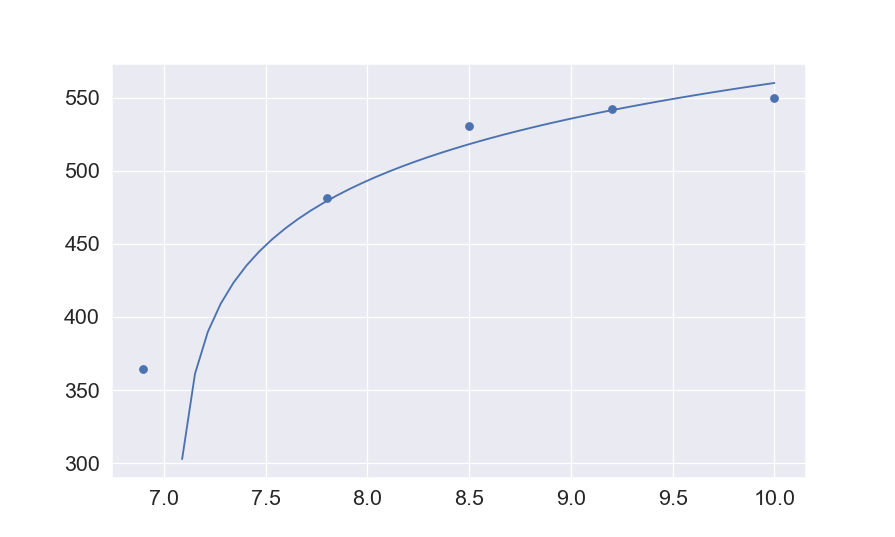

In [26]:
def log_curve(x, a, b, d):
    return a*(np.log(x + d)) + b

# sns.regplot(x=[6.6, 7.8, 8.1, 9.0, 9.9, 10.2], y=[np.mean(d['busvoltage'][1000:] / 1000) for d in dfs.values()], order=2)

x_esp = list(dfs.keys())
y = [df['power'].mean() for df in dfs.values()]

popt, _ = scipy.optimize.curve_fit(log_curve, x_esp, y)

for o in popt:
    print(f'{o:.30f}')

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(x=x_esp, y=y)
ax.plot(
    np.linspace(min(x_esp), max(x_esp)), 
    [log_curve(q, *popt) for q in np.linspace(6.6, 10.2)], 
)

<IPython.core.display.Javascript object>


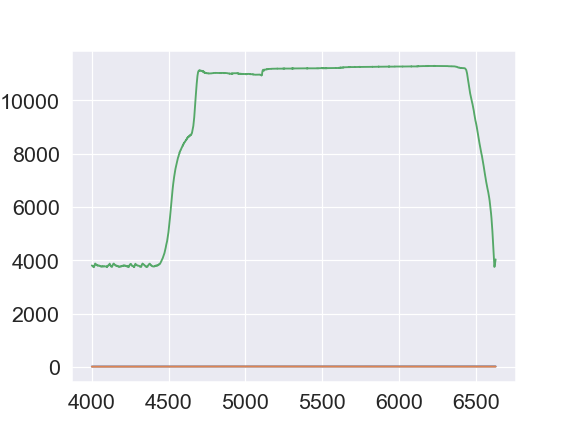

<AxesSubplot: >

In [27]:
plt.subplots()

df_vid = pd.read_json('data/video.jsonl', lines=True)
df_vid = df_vid.iloc[4000:]
df_vid.head()
df_vid['cumulative_flow'].plot()
df_vid['flow_rate'].plot()
df_vid['busvoltage'].plot()

In [28]:
def q_inv_log(v, a, b, c, d):
    return (np.exp((v - b) / a) - d) / c

estimate_fr = []

window_size = 100
for window_start in range(0, len(df_vid), window_size):
    if window_start + window_size >= len(df):
        break
        
    samples = df.iloc[window_start:window_start + window_size]
    v_bus = np.mean(samples['busvoltage'] / 1000)
    
    estimate_fr.append(q_inv_log(v_bus, *popt))
    
estimate_fr = np.array(estimate_fr)

fig, ax = plt.subplots()
ax.plot(estimate_fr)

TypeError: q_inv_log() missing 1 required positional argument: 'd'